/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


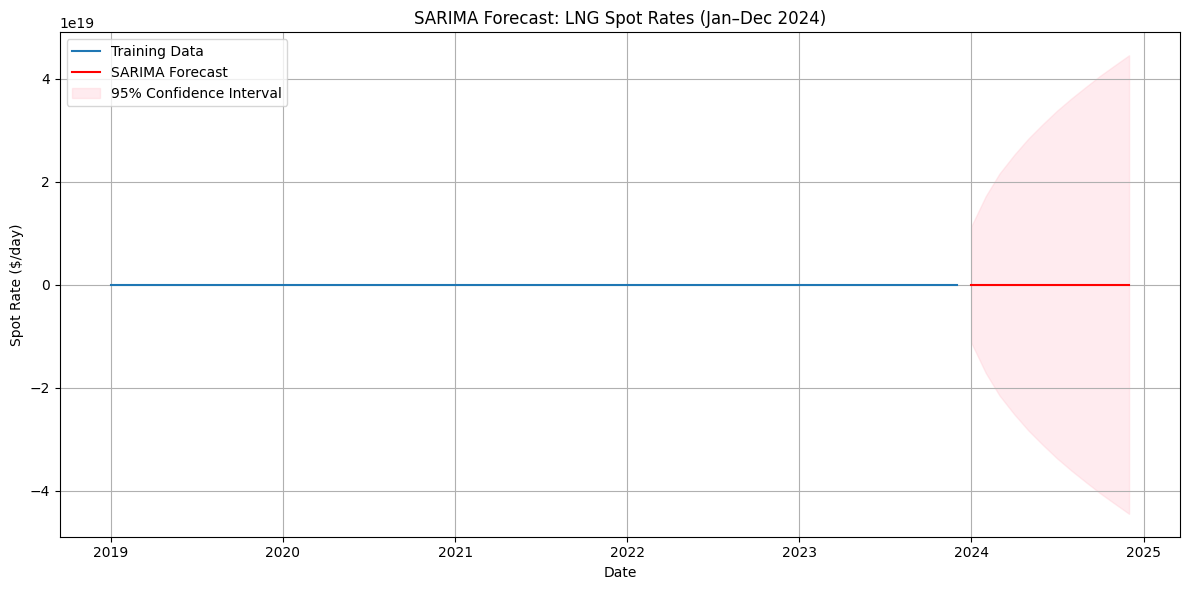

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("cleandata.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y')
df = df.set_index('Date')
target = 'LNG 174K CBM (2-stroke dual fuel) Spot Rate (avg., $/day)'

# Train/test split
cutoff = pd.Timestamp("2023-12-01")
train = df[df.index <= cutoff][target]

# Fit SARIMA
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_result = model.fit(disp=False)

# Forecast
forecast_steps = 12
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
pred_values = sarima_forecast.predicted_mean
conf_int = sarima_forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label="Training Data")
plt.plot(pred_values.index, pred_values, label="SARIMA Forecast", color='red')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label="95% Confidence Interval")
plt.title("SARIMA Forecast: LNG Spot Rates (Jan–Dec 2024)")
plt.ylabel("Spot Rate ($/day)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- Load actual 2024 values for comparison
true_2024 = df[(df.index > cutoff) & (df.index <= "2024-12-01")][target]

# Align SARIMA forecast with actuals
sarima_pred = pred_values.loc[true_2024.index]

# Evaluate SARIMA
sarima_mae = mean_absolute_error(true_2024, sarima_pred)
sarima_rmse = np.sqrt(mean_squared_error(true_2024, sarima_pred))
print(f"📊 SARIMA MAE: ${sarima_mae:,.2f} | RMSE: ${sarima_rmse:,.2f}")

# --- Ensemble with XGBoost
# Assuming you already have y_pred from XGBoost
# Align XGBoost predictions with SARIMA
xgb_pred_aligned = pd.Series(y_pred, index=true_2024.index)

# Ensemble: simple average
ensemble_pred = (xgb_pred_aligned + sarima_pred) / 2

# Evaluate ensemble
ensemble_mae = mean_absolute_error(true_2024, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(true_2024, ensemble_pred))
print(f"🤝 Ensemble MAE: ${ensemble_mae:,.2f} | RMSE: ${ensemble_rmse:,.2f}")


📊 SARIMA MAE: $98,491.61 | RMSE: $159,688.12


NameError: name 'y_pred' is not defined